In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-torch/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [131]:
cfg_default = dict(
    seed=0, save_dir=None, dtype='float32', device='cuda:0',
    
    img_size=128, d_state=16, perception='fullconv', kernel_size=3, 
    init_state="point", padding_mode="circular", dt=0.01, dropout=0.0, # changed dropout and initial state
    
    prompts="a circle;a square", spatial_scales="0.015625;1.0", clip_model="clip-vit-base-patch32",
    coef_alignment=1., coef_spatial_softmax=0.,
    
    rollout_steps=1024, bptt_steps=16, pool_size=1024,
    bs=8, lr=3e-4, n_iters=200000, clip_grad_norm=1.
)

seeds = np.arange(1)

# coef_spatial_softmax_sweep = [0., 1e-2, 3e-2, 1e-1]
coef_spatial_softmax_sweep = [0.]+np.logspace(-3, 0, num=15).tolist()

cfgs = []
for seed in seeds:
    for coef_spatial_softmax in coef_spatial_softmax_sweep:
            cfg = cfg_default.copy()
            cfg.update(seed=seed, coef_spatial_softmax=coef_spatial_softmax)
            cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_scale2/{seed}_{coef_spatial_softmax:.4f}")
            cfgs.append(cfg)

# print(cfgs)
print(len(cfgs))

16


In [132]:
commands = experiment_utils.create_commands(cfgs, prefix='python train_nca_temporal_emergence.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python train_nca_temporal_emergence.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_scale2/0_0.0000" --dtype="float32" --device="cuda:0" --img_size=128 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="point" --padding_mode="circular" --dt=0.01 --dropout=0.0 --prompts="a circle;a square" --spatial_scales="0.015625;1.0" --clip_model="clip-vit-base-patch32" --coef_alignment=1.0 --coef_spatial_softmax=0.0                   --rollout_steps=1024 --bptt_steps=16 --pool_size=1024 --bs=8 --lr=0.0003 --n_iters=200000 --clip_grad_norm=1.0
python train_nca_temporal_emergence.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_scale2/0_0.0010" --dtype="float32" --device="cuda:0" --img_size=128 --d_state=16 --perception="fullconv" --kernel_size=3 --init_state="point" --padding_mode="circular" --dt=0.01 --dropout=0.0 --prompts="a circle;a square" --spatial_scales="0.015625;1.0" --clip_model="clip-vit-base-patch32" --coef_alignment=1.0 --coef_spatial_sof

# Visualize Results

In [138]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [145]:
spatial_scales = [float(s) for s in cfg['spatial_scales'].split(';')]
crop_img_scales = [transforms.RandomResizedCrop(224, scale=(s, s), interpolation=InterpolationMode.NEAREST, ratio=(3./4., 4./3.)) for s in spatial_scales]
augment_img = transforms.Compose([
    # transforms.RandomRotation()
    # transforms.RandomPerspective(distortion_scale=0.5, p=1., fill=0.),
])

img_cropped = torch.stack([augment_img(crop_img(torch.from_numpy(rearrange(img, "B H W D -> B D H W")))) for crop_img in crop_img_scales])

img_cropped = rearrange(img_cropped.cpu().numpy(), "... D H W -> ... H W D")

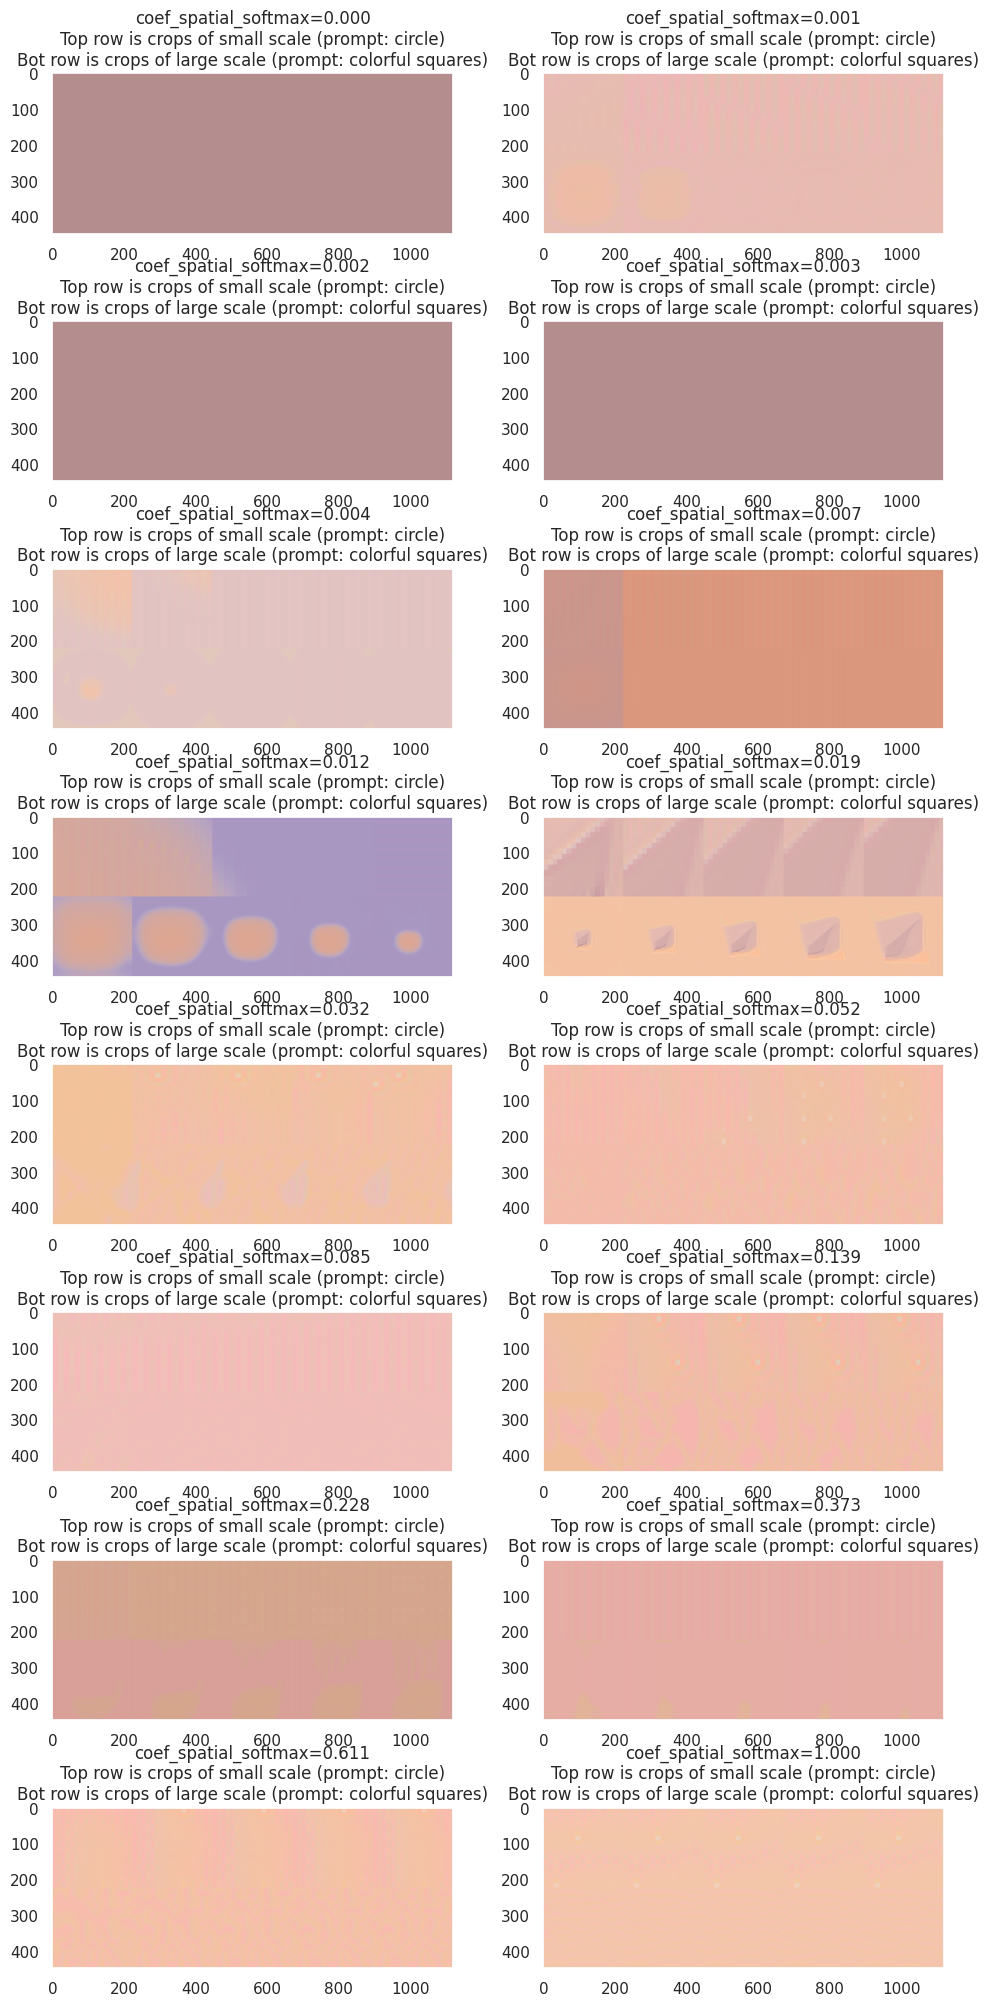

In [147]:
plt.figure(figsize=(10, 20))
iplt = 0

for cfg in cfgs:
    save_dir = cfg['save_dir']
    vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)
    img = vid[[200, 400, 600, 800, 1000]]

    img_cropped = torch.stack([augment_img(crop_img(torch.from_numpy(rearrange(img, "B H W D -> B D H W")))) for crop_img in crop_img_scales])
    img_cropped = rearrange(img_cropped.cpu().numpy(), "... D H W -> ... H W D")

    iplt += 1
    plt.subplot(8, 2, iplt)
    plt.imshow(rearrange(img_cropped, "R C H W D -> (R H) (C W) D"))
    plt.grid(False)

    coef_spatial_softmax = cfg['coef_spatial_softmax']
    plt.title(f"{coef_spatial_softmax=:.3f}\nTop row is crops of small scale (prompt: circle)\nBot row is crops of large scale (prompt: colorful squares)")

plt.tight_layout()
plt.show()
    

In [80]:
cfg = cfgs[3]

In [81]:
save_dir = cfg['save_dir']

In [82]:
vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)
img = vid[[200, 400, 600, 800, 1000]]
img.shape

(5, 128, 128, 3)

<InterpolationMode.NEAREST: 'nearest'>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4463058..3.0551305].


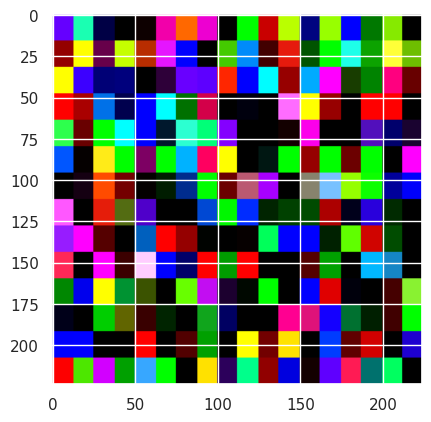

In [128]:
a = torch.randn(3, 128, 128)
plt.imshow(rearrange(crop_img_scales[0](a), "D H W -> H W D"))

In [97]:
print(img.shape)
print(img_cropped.shape)

(5, 128, 128, 3)
(2, 5, 224, 224, 3)


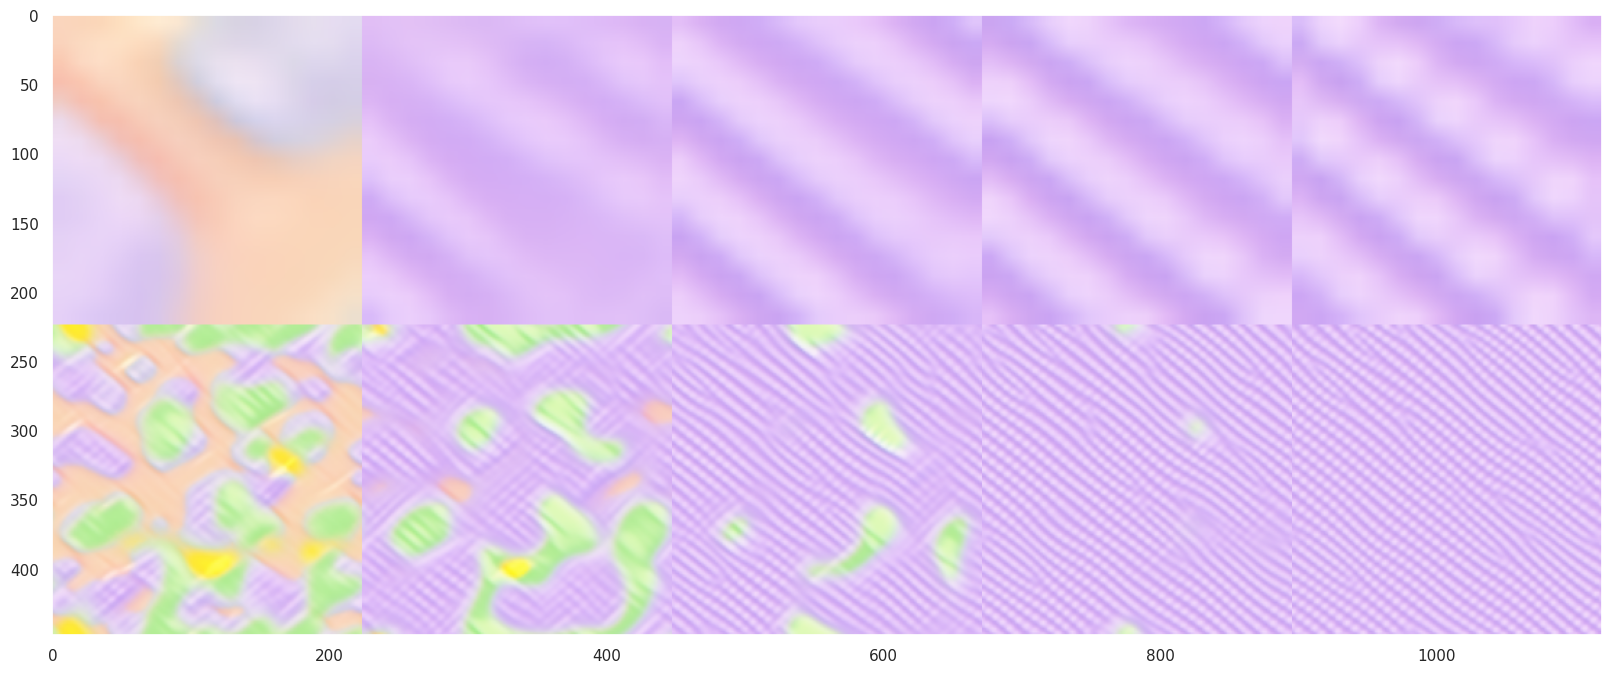

In [98]:
plt.figure(figsize=(20, 20))
plt.imshow(rearrange(img_cropped, "R C H W D -> (R H) (C W) D"))
plt.grid(False)

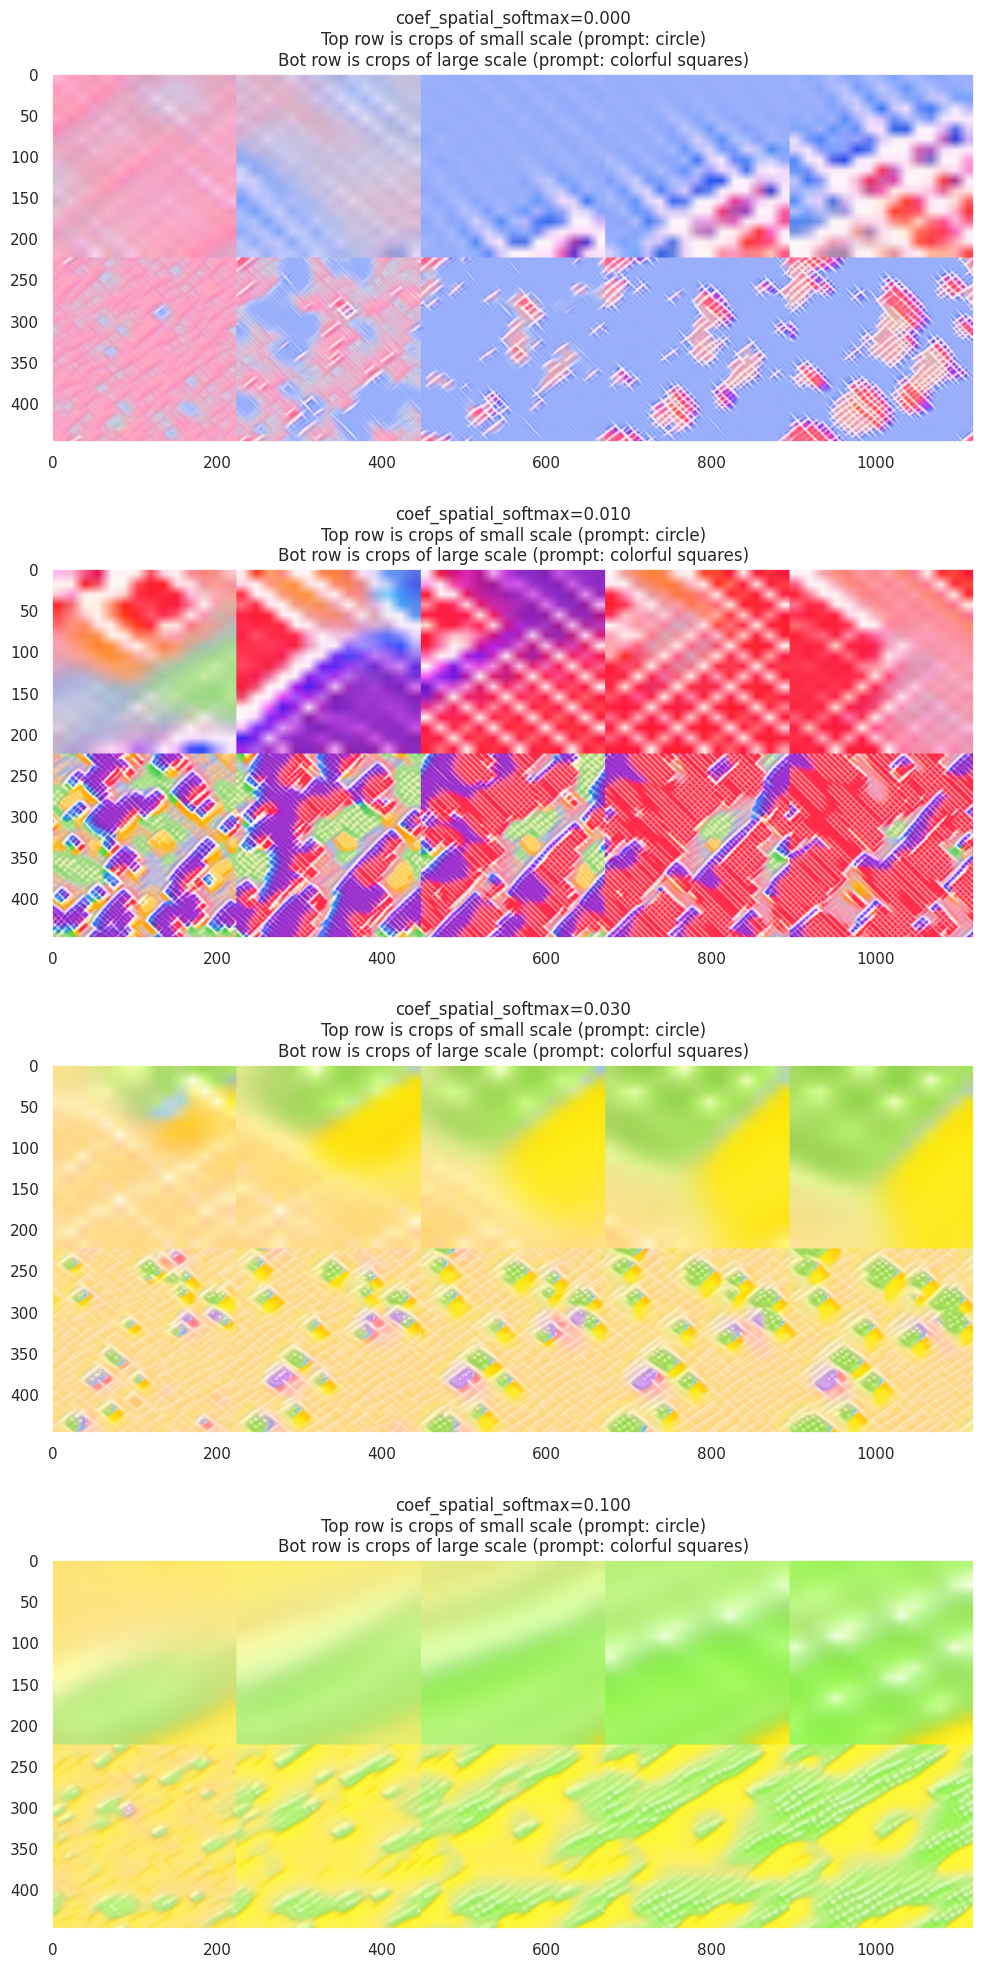

In [104]:
plt.figure(figsize=(10, 20))
iplt = 0

for cfg in cfgs:
    save_dir = cfg['save_dir']
    vid = util.load_pkl(save_dir, 'vid').astype(np.uint8)
    img = vid[[200, 400, 600, 800, 1000]]

    img_cropped = torch.stack([augment_img(crop_img(torch.from_numpy(rearrange(img, "B H W D -> B D H W")))) for crop_img in crop_img_scales])
    img_cropped = rearrange(img_cropped.cpu().numpy(), "... D H W -> ... H W D")

    iplt += 1
    plt.subplot(4, 1, iplt)
    plt.imshow(rearrange(img_cropped, "R C H W D -> (R H) (C W) D"))
    plt.grid(False)

    coef_spatial_softmax = cfg['coef_spatial_softmax']
    plt.title(f"{coef_spatial_softmax=:.3f}\nTop row is crops of small scale (prompt: circle)\nBot row is crops of large scale (prompt: colorful squares)")

plt.tight_layout()
plt.show()
    